In [1]:
import time
import numpy as np
import pandas as pd

from performance_analysis.data_acquisition import get_talang1_ret, get_kc_stock_pct, get_kc50_stock_list, get_kc50_ret
import plotly.express as px
import plotly.graph_objects as go

In [3]:
date = '2023-10-19'
talang1_ret = get_talang1_ret(date)
kc_stock_ret = get_kc_stock_pct(date).T.iloc[:,0].rename('科创板股票收益率')
kc50_stock_list = get_kc50_stock_list()

C:\ProgramData\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\ProgramData\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\Yz02\AppData\Roaming\Python\Python311\site-packages\rqdatac\client.py:241: UserWarning: Your account will be expired after  26 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "
C:\Users\Yz02\AppData\Roaming\Python\Python311\site-packages\rqdatac\client.py:202: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)
C:\Users\Yz02\AppData\Roaming\Python\Python311\site-packages\rqdatac\client.py:241: UserWarning: You

In [4]:
kc50_ret_s = kc_stock_ret[kc50_stock_list]
kc50_ret = get_kc50_ret(date)

C:\Users\Yz02\AppData\Roaming\Python\Python311\site-packages\rqdatac\client.py:202: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)
C:\Users\Yz02\AppData\Roaming\Python\Python311\site-packages\rqdatac\client.py:241: UserWarning: Your account will be expired after  26 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


In [20]:
from plotly.io import write_html
import plotly.io as pio
def hist_performance(kc_stock_ret, port_ret,kc50_ret, stock_name):
    counts, bins = np.histogram(kc_stock_ret.values, bins=100)
    bins = 0.5*(bins[1:] + bins[:-1])
    fig = px.bar(
        x=bins,
        y=counts,
        title=f'{stock_name}涨跌幅分布',
        labels={'x':'涨跌幅', 'y':'计数'},
        )
    fig.update_layout(
        xaxis_title="涨跌幅",
        yaxis_title="计数",
        title_x=0.5,
        legend_title="参数",
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="RebeccaPurple",
        ),
        width=1200,
        height=800,
    )
    line_dict = {
        '踏浪1号涨跌幅': {'value':port_ret,'color':'#F21526'},
        '科创50涨跌幅': {'value':kc50_ret,'color':'#71B5FC'},
        f'{stock_name}涨跌幅均值': {'value':np.mean(kc_stock_ret),'color':'green'},
        f'{stock_name}涨跌幅中位数': {'value':np.median(kc_stock_ret),'color':'orange'},
    }
    for label, item in line_dict.items():
        fig.add_traces(
            go.Scatter(x = [item['value'], item['value']], y = [0, max(counts)*1.1], mode='lines', name=label, line=dict(color=item['color'], width=1.5, dash='dash'))
        )
    fig.show()
    with open(f'./data/{stock_name}涨跌幅分布_{date}.html', 'w', encoding='utf-8') as f:
        write_html(fig,f)


In [28]:
kc_stock_ret[kc_stock_ret==kc_stock_ret.max()]

order_book_id
688256.XSHG    0.2
Name: 科创板股票收益率, dtype: float64

In [22]:
hist_performance(kc_stock_ret, talang1_ret, kc50_ret, '科创板')
hist_performance(kc50_ret_s, talang1_ret, kc50_ret, '科创50')

In [ ]:
def gen_statistics(kc_stock_ret, stock_name):
    statistics_s = pd.Series(data = {
        '上涨数': len(kc_stock_ret[kc_stock_ret>0]),
        '下跌数': len(kc_stock_ret[kc_stock_ret<0]),
        '持平数': len(kc_stock_ret[kc_stock_ret==0]),
        '上涨比例': len(kc_stock_ret[kc_stock_ret>0])/len(kc_stock_ret),
        '均值': np.mean(kc_stock_ret),
        '中位数': np.median(kc_stock_ret),
        '标准差': np.std(kc_stock_ret),
        '最大值': np.max(kc_stock_ret),
        '最小值': np.min(kc_stock_ret),
    }, name=stock_name)
    return statistics_s

def gen_statistics_table(kc_stock_ret, kc50_stock_ret):
    kc_stock_statistics = gen_statistics(kc_stock_ret, '科创板')
    kc50_stock_statistics = gen_statistics(kc50_stock_ret, '科创50')
    statistics_df = pd.concat([kc_stock_statistics, kc50_stock_statistics], axis=1)
    return statistics_df
    

In [ ]:
statistics_df = gen_statistics_table(kc_stock_ret, kc50_ret_s)

In [ ]:
from IPython.display import HTML

In [ ]:
def format_number(value):
    if value.is_integer():
        return int(value)
    else:
        return f'{value:.2%}'

In [ ]:
formatted_df = statistics_df.applymap(format_number)
df_html = formatted_df.to_html()
HTML(df_html)

In [ ]:
from util.utils import send_email, SendEmailInfo
subject = f'[踏浪1号当日表现一览]{date}'
content = f"""
<table width="800" border="0" cellspacing="0" cellpadding="4">
<tr>
<td bgcolor="#CECFAD" height="30" style="font-size:21px"><b>踏浪1号在科创板表现一览</b></td>
</tr>
<td bgcolor="#EFEBDE" height="100" style="font-size:13px">
"""
content += f"""
<p>科创板和科创50成分股表现统计：</p>
<center>{df_html}</center>
<p>踏浪1号当日收益率：{format_number(talang1_ret)}</p>
<p>科创50当日收益率：{format_number(kc50_ret)}</p>
<p>科创板股票涨跌幅分布：</p>


<p>科创50成分股涨跌幅分布：</p>
""" 
send_email(subject, content, receiver=SendEmailInfo.department['research'][0])



C:\Users\Yz02\AppData\Local\Temp\ipykernel_28968\2154339883.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




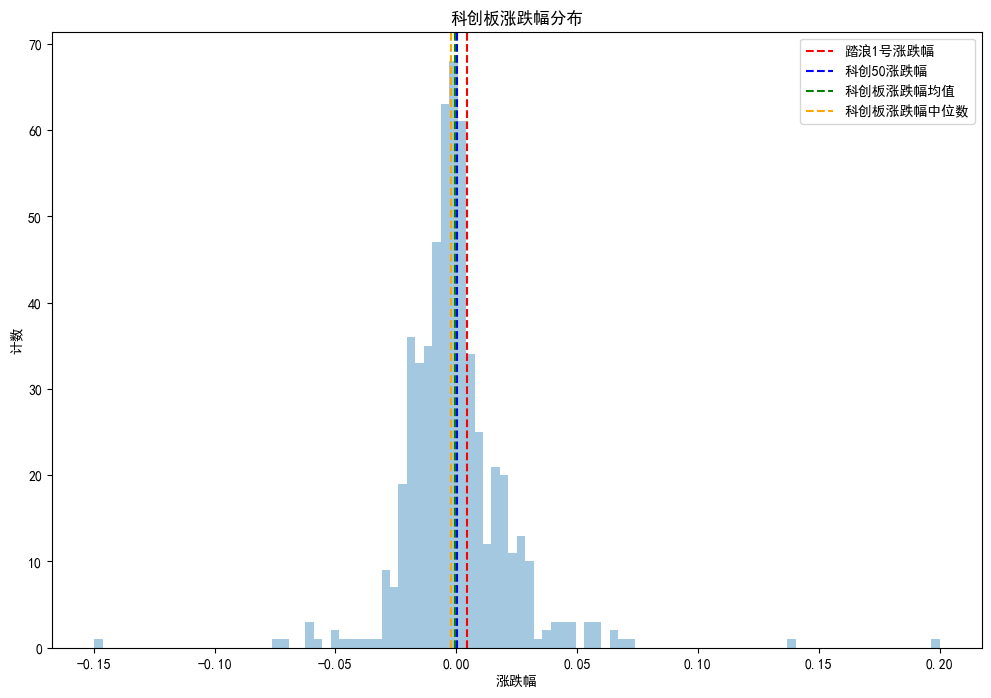

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(12,8))
sns.distplot(kc_stock_ret, bins=100, kde=False)
plt.title('科创板涨跌幅分布')
plt.xlabel('涨跌幅')
plt.ylabel('计数')
plt.axvline(x=talang1_ret, color='r', linestyle='--', label='踏浪1号涨跌幅')
plt.axvline(x=kc50_ret, color='b', linestyle='--', label='科创50涨跌幅')
plt.axvline(x=np.mean(kc_stock_ret), color='g', linestyle='--', label='科创板涨跌幅均值')
plt.axvline(x=np.median(kc_stock_ret), color='orange', linestyle='--', label='科创板涨跌幅中位数')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.legend()
plt.savefig(f'./data/科创板涨跌幅分布_{date}.png')